## Notebook for examining models individually

In [1]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER, model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import seaborn as sns
from sklearn.neighbors import NearestNeighbors    

In [2]:
new_title_lookup = {'predictive': 'output uncertainty injection', 'feature': 'input uncertainty injection'}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

In [72]:
uniform = True
just_loss = False

BETA = 0.5

prescription = "linear_homoskedastic"
dim_list = ["0D", "0D", "0D", "0D",
            "2D", "2D", "2D", "2D",
            "0D", "0D", "0D", "0D",
            "2D", "2D", "2D", "2D",
            "0D", "0D", "0D", "0D",
            "2D", "2D", "2D", "2D"]
inject_type_list = ["predictive", "predictive", "feature", "feature",
                    "predictive", "predictive", "feature", "feature",
                    "predictive", "predictive", "feature", "feature",
                    "predictive", "predictive", "feature", "feature",
                    "predictive", "predictive", "feature", "feature",
                    "predictive", "predictive", "feature", "feature"]
noise_list = ["low", "low", "low", "low",
              "low", "low", "low", "low",
              "medium", "medium", "medium", "medium",
              "medium", "medium", "medium", "medium",
              "high", "high", "high", "high",
              "high", "high", "high", "high"]
              
              
model_list = ["DE", "DER", "DE", "DER",
              "DE", "DER", "DE", "DER",
              "DE", "DER", "DE", "DER",
              "DE", "DER", "DE", "DER",
              "DE", "DER", "DE", "DER",
              "DE", "DER", "DE", "DER"]
'''
m_list = [0, 0, 0, 0,
          0, 0, 0, 0,
          0, 0, 0, 0,
          0, 0, 0, 0,
          0, 0, 0, 0,
          0, 0, 0, 0]
'''


dim_list = ["2D"]
inject_type_list = ["predictive"]
noise_list = ["medium"]
model_list = ["DE"]
m = 5



assert len(dim_list) == len(inject_type_list) == len(noise_list) == len(model_list), "lengths are not the same"
    
epoch = 99

predictive 2D DE medium 5
setting up DE
final chk loaded
preparing test set
2D data sim
all values in y_pred are not the same
[0.00257764 0.00264885 0.00262166 ... 0.00249407 0.00266459 0.0034339 ]


/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepu

medium predictive 2D DE m =  5
Training loss final epoch: -0.1310855829053455
Validation loss final epoch: -0.1462526023387909
Training MSE loss final epoch: 0.0030084147738913694
Validation MSE loss final epoch: 0.002632393268868327


<Figure size 2000x800 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

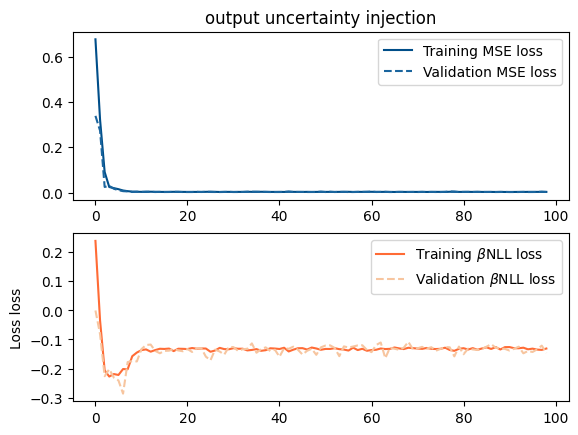

In [73]:
for d in range(len(dim_list)):
    index = d # + 1
    dim = dim_list[index]
    inject_type = inject_type_list[index]
    noise = noise_list[index]
    model = model_list[index]
    '''
    if inject_type == "predictive" and model == "DE" and noise == "low" and dim == "2D":
        m = 3
    else:
        m = 0
    '''
    print(inject_type, dim, model, noise, m)
    #m = m_list[i]
    if dim == "0D":
        if uniform:
            size_df = 10000
        else:
            size_df = 1000
    elif dim == "2D":
        if uniform:
            size_df = 175000
        else:
            size_df = 5000
    path = "../DeepUQResources/checkpoints/"
    if not just_loss:
        if model == "DER":
            print('setting up DER')
            setupmodel, lossFn = model_setup_DER(
                model, DEVICE, n_hidden=64, data_type=dim)
            loss = "DER"
            COEFF = 0.01
            file_name = (
                str(path)
                + f"{model}_{prescription}_{inject_type}_{dim}"
                + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            try:
                chk = torch.load(file_name, map_location=DEVICE)
            except FileNotFoundError:
                print('no file found')
                continue
            print('final chk loaded')
        elif model == "DE":
            print('setting up DE')
            loss = "bnll_loss"
            setupmodel, lossFn = model_setup_DE(
                                loss, DEVICE, n_hidden=64, data_type=dim)
            BETA = 0.5
            file_name = (
                str(path) +
                f"{model}_{prescription}_{inject_type}_{dim}"
                f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            try:
                chk = torch.load(file_name, map_location=DEVICE)
            except FileNotFoundError:
                continue
            print('final chk loaded')
        # define the model at this epoch
        setupmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        setupmodel.eval()
    
        print('preparing test set')
        data = DataPreparation()
        if dim == "0D":
            print('0D data sim')
            data.sample_params_from_prior(size_df)
            if inject_type == "feature":
                data.simulate_data(
                    data.params,
                    noise,
                    "linear_homoskedastic",
                    x=np.linspace(0, 10, 100),
                    inject_type=inject_type,
                    seed=41,
                    vary_sigma=True,
                )
            elif inject_type == "predictive":
                sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
                data.simulate_data(
                    data.params,
                    sigma,
                    "linear_homoskedastic",
                    x=np.linspace(0, 10, 100),
                    inject_type=inject_type,
                    seed=41,
                )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
            model_inputs = inputs
            model_outputs = ys_array
            '''
            print(np.shape(model_inputs))
            plt.clf()
            plt.scatter(model_inputs[:,1], model_outputs)
            plt.show()
            '''
        elif dim == "2D":
            print('2D data sim')
            sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
            data.sample_params_from_prior(
                size_df,
                low=[0, 1, -1.5],
                high=[0.01, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                sigma=sigma,
                image_size=32,
                inject_type=inject_type,
                rs=41)
        if uniform:
            # then we'll need to do the uniform thing
            model_inputs, model_outputs = DataPreparation.select_uniform(
                model_inputs, model_outputs, dim, verbose=False, rs=40
            )
        x_test = model_inputs
        y_test = model_outputs
        y_pred = setupmodel(
            torch.Tensor(x_test
                )
            ).detach().numpy()

        if np.all(y_pred[:, 1] == y_pred[0, 1]):
            # All values are the same
            print("All values in y_pred[:,1] are the same.")
            STOP
        else:
            print('all values in y_pred are not the same')
            print(y_pred[:, 1])
        if dim == "2D":
            # Create a figure with 5 subplots in a horizontal row
            fig, axes = plt.subplots(2, 5, figsize=(20, 8)) # Adjust the figsize as needed
            
            # Loop through each subplot
            for i in range(10):
                ax = axes.flat[i]
                ax.imshow(x_test[i, :, :], aspect='auto')
                mu = round(y_pred[i,0], 3)
                if model == "DE":
                    sig = round(np.sqrt(y_pred[i,1]), 3)
                elif model == "DER":
                    gamma, nu, alpha, beta = y_pred[i, 0], y_pred[i, 1], y_pred[i, 2], y_pred[i, 3]
                    sig = round(np.sqrt(beta * (1 + nu) / (alpha * nu)),2)
                ax.set_title('true = '+str(round(y_test[i],3))
                             +', pred = '+str(mu)+' +/- '+str(sig))
                ax.figure.colorbar(ax.images[0], ax=ax, fraction = 0.046)
                ax.set_aspect('equal')
                ax.axis('off')
            
            # Show the complete figure
            plt.tight_layout()
        elif dim == "0D":
            plt.scatter(
                    y_test,
                    y_pred[:, 0],
                    #color=color_list[i],
                    #label=r"$\sigma = $" + str(sigma_list[i]),
                    s=3,
                )
            plt.xlabel('true value')
            plt.ylabel('predicted value')
        plt.savefig(f'../../../Desktop/model_validation/validation_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)
    
        plt.clf()
    
        # Also make a histogram plot of the uncertainties to see how they are distributed. Also examine if there's a trend with true or predicted value.
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
        
        plt.hist(sig, bins = 50)
        plt.xlabel(r'$\sigma_{al}$ values')
        #plt.show()
        plt.savefig(f'../../../Desktop/model_validation/hist_validation_u_al_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)
    
        plt.clf()
        # make a sigma residual plot
    
        sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
        sig_true = sigma_y_lookup[noise]
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
        
        sig_true_array = np.full_like(sig, sig_true)
        # Create the plot
        sns.jointplot(x=sig-sig_true_array, y=y_test, kind="scatter", marginal_kws=dict(bins=50, fill=True))
        
        plt.ylabel(r'$y_{\rm true}$')
        plt.xlabel(r'$\sigma_{al}$ - $\sigma_{y}$')
        plt.tight_layout()
        plt.savefig(f'../../../Desktop/model_validation/u_al_residual_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)

        '''
        plt.clf()
    
        # Okay is there a trend where the difference in predicted uncertainty is similar to the difference in predicted y value?
        sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
        sig_true = sigma_y_lookup[noise]
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
        fig, ax = plt.subplots(figsize=(8, 6))
        
        sig_true_array = np.full_like(sig, sig_true)
        # histogram with density plot
        sns.histplot(x=sig-sig_true_array, y=y_pred[:, 0] - y_test, ax=ax, bins=50, pthresh=0.1, cmap="mako", cbar=True)
        sns.kdeplot(x=sig-sig_true_array, y=y_pred[:, 0] - y_test, ax=ax, color='green', levels=5)
        #sns.histplot(x=, y=, kind="scatter", marginal_kws=dict(bins=50, fill=True))
        
        plt.ylabel(r'$y_{\rm pred} - y_{\rm true}$')
        plt.xlabel(r'$\sigma_{al}$ - $\sigma_{y_{\rm true}}$')
        plt.tight_layout()
        plt.savefig(f'../../../Desktop/model_validation/delta_u_al_and_y_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)
        '''
    
        # I'd like to see how the difference in uncertainty trends with training set density of that particular true y value. To estimate this
    
    
        sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
        sig_true = sigma_y_lookup[noise]
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
        
        sig_true_array = np.full_like(sig, sig_true)
        
        # density statistic for y axis
        k = 5  # You can adjust the number of neighbors
        nbrs = NearestNeighbors(n_neighbors=k).fit(y_pred[:, 0].reshape(-1, 1))
        distances, _ = nbrs.kneighbors(y_pred[:, 0].reshape(-1, 1))
        
        # The k-NN density is the inverse of the average distance to the k nearest neighbors
        knn_density = 1.0 / (np.mean(distances, axis=1) + 1e-10)  # Small epsilon to avoid division by zero
        
        # Define the limits
        lower_y_limit = 0
        upper_y_limit = 2 * np.mean(knn_density)
    
        #print('min, mean, max', np.min(knn_density), np.mean(knn_density), np.max(knn_density))
        
        # Filter the data based on y-limits
        filtered_y = knn_density[(knn_density >= lower_y_limit) & (knn_density <= upper_y_limit)]
        filtered_x = np.abs(sig-sig_true_array)[(knn_density >= lower_y_limit) & (knn_density <= upper_y_limit)]
    
        sns.histplot(x=filtered_x, y=filtered_y, bins=100, pthresh=0, cmap="viridis")
        #plt.ylim([0,100000])
        
        #sns.jointplot(x=sig-sig_true_array, y=knn_density, kind="scatter", marginal_kws=dict(bins=50, fill=True))
        
        plt.ylabel(r'kNN distance of $y_{\rm pred}$, higher value means less dense')
        plt.xlabel(r'|$\sigma_{al}$ - $\sigma_{y}$|')
        plt.savefig(f'../../../Desktop/model_validation/density_delta_u_hist_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)

        '''
        plt.clf()
    
        # It looks like the closer together ys are, the higher the difference in predicted sigma value from the true sigma value, so that disproves the packed data thing and supports the fact that it might be a direct to y correlation.
    
        sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
        sig_true = sigma_y_lookup[noise]
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
        
        sig_true_array = np.full_like(sig, sig_true)
        # Create the plot
        sns.jointplot(x=sig, y=y_pred[:,0], kind="scatter", marginal_kws=dict(bins=50, fill=True))
        
        plt.ylabel(r'$y_{\rm pred}$')
        plt.xlabel(r'$\sigma_{al}$')
        plt.ylim([0,2.0])
        #plt.show()
        plt.savefig(f'../../../Desktop/model_validation/u_al_y_pred_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)

        # also do a point plot for the two deltas
        plt.clf()
    
        # It looks like the closer together ys are, the higher the difference in predicted sigma value from the true sigma value, so that disproves the packed data thing and supports the fact that it might be a direct to y correlation.
    
        sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
        sig_true = sigma_y_lookup[noise]
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
        
        sig_true_array = np.full_like(sig, sig_true)
        # Create the plot
        sns.jointplot(x=sig - sig_true, y=y_pred[:,0] - y_test, kind="scatter", marginal_kws=dict(bins=50, fill=True))
        
        plt.ylabel(r'$y_{\rm pred} - y_{\rm true}$')
        plt.xlabel(r'$\sigma_{\rm al} - \sigma_{\rm y}$')
        #plt.ylim([0,2.0])
        plt.tight_layout()
        #plt.show()
        plt.savefig(f'../../../Desktop/model_validation/delta_u_al_delta_y_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)
        '''

        # also do a point plot for the two deltas
        plt.clf()
    
        # It looks like the closer together ys are, the higher the difference in predicted sigma value from the true sigma value, so that disproves the packed data thing and supports the fact that it might be a direct to y correlation.
    
        sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
        sig_true = sigma_y_lookup[noise]
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))

        # Create the JointGrid
        g = sns.JointGrid(x=sig, y=y_pred[:, 0] - y_test)
        
        # Plot a hexbin instead of scatterplot
        hb = g.ax_joint.hexbin(x=sig, y=y_pred[:, 0] - y_test, C=y_test, gridsize=30, cmap='viridis', reduce_C_function=np.mean)
        
        # Add marginal histograms or KDEs
        g.plot_marginals(sns.histplot, kde=True, color="gray")

        # Ensure that the x-limits of the marginal plot match the 2D plot
        g.ax_marg_x.set_xlim(g.ax_joint.get_xlim())
        
        # Add colorbar for the hexbin plot
        cb = plt.colorbar(hb, ax=g.ax_joint, label='$y_{test}$')
        #cb.set_label('$y_{\rm test}$')
        
        # Plot point plots for deltas on top of the hexbin
        #sns.pointplot(x=sig, y=y_pred[:, 0] - y_test, ax=g.ax_joint, color='red', alpha=0.6)
        
        # Labeling axes
        g.ax_joint.set_ylabel(r'$y_{pred} - y_{true}$')
        g.ax_joint.set_xlabel(r'$\sigma_{al}$')
        
        # Adjust layout and save the plot
        plt.tight_layout()
        plt.savefig(f'../../../Desktop/model_validation/3D_u_al_delta_y_y_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)


        '''
        plt.clf()
    
        # Investigate what test examples look like at the high $y_{pred}$ end of things.
    
        plotted_number = 0
        if dim == "2D":
            # Create a figure with 5 subplots in a horizontal row
            fig, axes = plt.subplots(2, 5, figsize=(20, 8)) # Adjust the figsize as needed
            
            # Loop through each subplot
            for i in range(100):
                if y_pred[i,0] < 3:
                    continue
                if plotted_number > 11:
                    break
                ax = axes.flat[plotted_number]
                ax.imshow(x_test[i, :, :], aspect='auto')
                mu = round(y_pred[i,0], 3)
                if model == "DE":
                    sig = round(np.sqrt(y_pred[i,1]), 3)
                elif model == "DER":
                    gamma, nu, alpha, beta = y_pred[i, 0], y_pred[i, 1], y_pred[i, 2], y_pred[i, 3]
                    sig = round(np.sqrt(beta * (1 + nu) / (alpha * nu)),2)
                ax.set_title('true = '+str(round(y_test[i],3))
                             +', pred = '+str(mu)+' +/- '+str(sig))
                ax.figure.colorbar(ax.images[0], ax=ax, fraction = 0.046)
                ax.set_aspect('equal')
                ax.axis('off')
                plotted_number += 1
            
            # Show the complete figure
            plt.tight_layout()
        elif dim == "0D":
            for i in range(len(y_test)):
                if y_pred[i,0] < 3:
                    continue
                if plotted_number > 50:
                    break
        
                if model == "DE":
                    sig = np.sqrt(y_pred[i,1])
                elif model == "DER":
                    gamma, nu, alpha, beta = y_pred[i, 0], y_pred[i, 1], y_pred[i, 2], y_pred[i, 3]
                    sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
                plt.errorbar(
                        y_test[i],
                        y_pred[i, 0],
                        yerr = sig,
                        capsize=5
                        #color=color_list[i],
                        #label=r"$\sigma = $" + str(sigma_list[i]),
                        #s=30,
                    )
                plt.scatter(
                        y_test[i],
                        y_pred[i, 0],
                        #color=color_list[i],
                        #label=r"$\sigma = $" + str(sigma_list[i]),
                        s=30,
                    )
                plotted_number += 1
            plt.plot([3,5],[3,5], ls='--', color='grey')
            plt.xlabel('true value')
            plt.ylabel('predicted value')
        plt.savefig(f'../../../Desktop/model_validation/validation_high_vals_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)
        '''
        plt.clf()
    
        # residual plot
        fig = plt.figure()
        ax0 = fig.add_subplot(211)
        if model == "DE":
            sig = np.sqrt(y_pred[:,1])
        elif model == "DER":
            gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
            sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
        
        sns.histplot(x=y_test, y=y_pred[:, 0], ax=ax0, bins=70, cmap='viridis')
        
        ax1 = fig.add_subplot(212)
        
        sns.histplot(x=y_test, y=y_pred[:, 0] - y_test, ax=ax1, bins=70, cmap='viridis')
        #plt.colorbar(frac=0.046)
        
        ax1.axhline(y=0, ls='--', color='grey')
        ax1.set_xlabel('true value')
        ax0.set_ylabel('predicted y value')
        ax1.set_ylabel('residual ( y predicted - y true)') #/ true')
        ax0.set_title(new_title_lookup[inject_type])
        #ax0.legend()
        #ax1.legend()
        
        x_limits = [min(y_test), max(y_test)]
        
        # Set the same x-axis limits for both subplots
        ax0.set_xlim(x_limits)
        ax1.set_xlim(x_limits)
        
        plt.savefig(f'../../../Desktop/model_validation/parity_and_residuals_test_hist_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)

    plt.clf()

    # loss plot with epoch
    fig = plt.figure()
    ax0 = fig.add_subplot(211)
    ax1 = fig.add_subplot(212)
    
    color_list = ['#004E89','#1A659E','#FF6B35','#F7C59F']
    mse_loss = []
    loss_value = []
    train_mse_loss = []
    train_loss = []
    for e in range(epoch):
        if model == "DER":
            file_name = (
                str(path)
                + f"{model}_{prescription}_{inject_type}_{dim}"
                + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{e}"
            )
        elif model == "DE":
            file_name = (
                str(path) +
                f"{model}_{prescription}_{inject_type}_{dim}"
                f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{e}"
            )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        mse_loss.append(chk["valid_mse"])
        loss_value.append(chk["valid_loss"])
        train_mse_loss.append(chk["train_mse"])
        train_loss.append(chk["train_loss"])
    if len(train_mse_loss) != 99:
        print('training MSE loss at epoch 99', train_mse_loss)
        print('training loss at epoch 99', train_loss)
        print('validation MSE loss at epoch 99', mse_loss)
        print('validation loss at epoch 99', loss_value)
        continue
    ax0.plot(
            range(epoch),
            train_mse_loss,
            color=color_list[0],
            label=r"Training MSE loss",
            #s=5,
        )
    ax0.plot(
            range(epoch),
            mse_loss,
            color=color_list[1],
            label=r"Validation MSE loss",
            ls = '--'
            #s=5,
        )
    if model == "DER":
        ax1.plot(
                range(epoch),
                train_loss,
                color=color_list[2],
                label=r"Training NIG loss",
                #s=5,
            )
        ax1.plot(
                range(epoch),
                loss_value,
                color=color_list[3],
                label=r"Validation NIG loss",
                ls = '--'
                #s=5,
            )
    elif model == "DE":
        ax1.plot(
                range(epoch),
                train_loss,
                color=color_list[2],
                label=r"Training $\beta$NLL loss",
                #s=5,
            )
        ax1.plot(
                range(epoch),
                loss_value,
                color=color_list[3],
                label=r"Validation $\beta$NLL loss",
                ls = '--'
                #s=5,
            )
    
    
    plt.ylabel('MSE loss') #/ true')
    plt.ylabel('Loss loss')
    ax0.set_title(new_title_lookup[inject_type])
    ax0.legend() 
    ax1.legend()
    plt.savefig(f'../../../Desktop/model_validation/loss_{model}_{noise}_{inject_type}_{dim}_{size_df}.png', dpi=1000)

    print(noise, inject_type, dim, model, 'm = ', m)

    print(f'Training loss final epoch: {train_loss[-1]}')
    print(f'Validation loss final epoch: {loss_value[-1]}')
    print(f'Training MSE loss final epoch: {train_mse_loss[-1]}')
    print(f'Validation MSE loss final epoch: {mse_loss[-1]}')
    '''
    if d > 0:
        print('d', d, 'stopping here')
        STOP
    '''

Remake the figure but with a histogram to better show density of the residuals.

In [ ]:
fig = plt.figure()
ax0 = fig.add_subplot(211)
if model == "DE":
    sig = np.sqrt(y_pred[:,1])
elif model == "DER":
    gamma, nu, alpha, beta = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
    sig = np.sqrt(beta * (1 + nu) / (alpha * nu))
ax0.errorbar(
            y_test,
            y_pred[:, 0],
            yerr=sig,
            color='black',
            #color=color_list[i],
            capsize=3,
            ls='None'
        )
ax0.scatter(
            y_test,
            (y_pred[:, 0]), # / outputs_test,
            color='black',
            #color=color_list[i],
            label=r"noise = "+noise,
            s=5,
        )
ax1 = fig.add_subplot(212)
ax1.scatter(
            y_test,
            (y_pred[:, 0] - y_test), # / outputs_test,
            color='black',
            #color=color_list[i],
            label=r"noise = "+noise,
            s=5,
        )
ax1.axhline(y=0, ls='--', color='grey')
ax1.set_xlabel('true value')
ax0.set_ylabel('predicted value')
ax1.set_ylabel('residual (predicted - true)') #/ true')
ax0.set_title(new_title_lookup[inject_type])
ax0.legend()
ax1.legend()
plt.savefig(f'../../../Desktop/parity_and_residuals_test_{model}_{noise}_{inject_type}_{dim}.png', dpi=1000)